# Supplemental Exploration

In this notebook, we will be exploring the data in greater detail. The question being asked of the data may only loosely relate to our main analytical motivations, nevertheless, they will satisfy curiosities and will likely produce interesting results.

A few of the items that will be explored:
* number of words
* number of paragraphs
* number of chars
* average word len
* sentence-wise sentiment
* post frequency graph, see if there are spikes in summer/fall for different admissions seasons
* top contributors

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import json
import warnings
import string
from pathlib import Path
import itertools
import collections
from collections import Counter
import pickle

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
pd.plotting.register_matplotlib_converters() # corrects pandas FutureWarning
import seaborn as sns
from bs4 import BeautifulSoup

import unidecode
import textblob
from textblob import TextBlob

import gensim
from gensim import corpora, models
import gensim.downloader as api
from gensim.models.coherencemodel import CoherenceModel
# Ignore smart open warning until update pushed to conda: https://github.com/RaRe-Technologies/gensim/pull/2530
warnings.filterwarnings('ignore',message='.+smart_open.+')

import nltk
from nltk.corpus import cmudict, stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import spacy
from spacy.tokens import Doc, Span, Token

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF, TruncatedSVD
from sklearn.cluster import KMeans

from FaiText import Tokenizer

In [3]:
nlp = spacy.load("en_core_web_md")

In [30]:
# take all spacy stopwords and overlap from gensim's and nltk's
stopwords_lg = nlp.Defaults.stop_words | (gensim.parsing.preprocessing.STOPWORDS & set(stopwords.words('english')))

# Old Google stopwords list from the 2000's. From: https://www.ranks.nl/stopwords
# plus a few custom add-ins
stopwords_sm = set(
    ['i','a','about','an','are','as','at','be','by','for',
     'from','how','in','is','it','of','on','or','that','the','this',
     'to','was','what','when','where','who','will','with'] # -com, -www
    + ['and','your','essay','have','so','my'] 
    + list(string.punctuation))

## Data

In [4]:
full_df = pd.read_pickle('data/proc_data/full_df.pkl')

In [5]:
full_df.head(3)

,name,post_content,post_date,seqnum,slug,url_id,user_id,user_likes,user_posts,user_threads,username,tokens,doc_id
0,Yeu Deck Ngui,"Hi guys, I would need help reviewing this stud...","Mar 16, 2019",0,study-plan-canada-permit-meng-civil-env-82750,82750,112438,0.0,0,1,decimo1993,"[xxmaj, hi, guys, ,, i, would, need, help, rev...",82750_0
1,Mary Rose,"Yeu, I am afraid that this is not a valid stud...","Mar 17, 2019",1,study-plan-canada-permit-meng-civil-env-82750,82750,99412,2001.0,7529,0,Holt,"[xxmaj, yeu, ,, i, am, afraid, that, this, is,...",82750_1
2,snow,Please confine your statement to no more than ...,"Mar 17, 2019",0,application-statement-msc-electronic-82755,82755,112507,0.0,0,1,Airydisc,"[ , xxhlb, xxmaj, please, confine, your, state...",82755_0


In [6]:
df_text = pd.read_pickle('data/proc_data/minparse/full_text_minproc.pkl')
op_idx = np.load('data/proc_data/minparse/op_idx.npy')
op_rep_idx = np.load('data/proc_data/minparse/op_rep_idx.npy')
crit_idx = np.load('data/proc_data/minparse/crit_idx.npy')

In [7]:
df_op = df_text.loc[op_idx]
df_op.head()

,doc_id,url_id,user_id,seqnum,post_content,tokens
0,82750_0,82750,112438,0,"Hi guys, I would need help reviewing this stud...","[xxmaj, hi, guys, ,, i, would, need, help, rev..."
2,82755_0,82755,112507,0,Please confine your statement to no more than ...,"[xxmaj, please, confine, your, statement, to, ..."
3,82784_0,82784,112553,0,I really need help in this particular essay. T...,"[i, really, need, help, in, this, particular, ..."
8,82777_0,82777,112484,0,"Hello Everyone,\nI would like to have a review...","[xxmaj, hello, xxmaj, everyone, ,, \n , i, wou..."
9,82767_0,82767,112524,0,one of the best economics graduate program in ...,"[one, of, the, best, economics, graduate, prog..."


In [8]:
df_crit = df_text.loc[crit_idx]
df_crit.head()

,doc_id,url_id,user_id,seqnum,post_content,tokens
1,82750_1,82750,99412,1,"Yeu, I am afraid that this is not a valid stud...","[xxmaj, yeu, ,, i, am, afraid, that, this, is,..."
4,82755_1,82755,112560,1,"Since this is an academic paper, please remove...","[xxmaj, since, this, is, an, academic, paper, ..."
5,82784_1,82784,112560,1,This comments are just some suggestions that m...,"[xxmaj, this, comments, are, just, some, sugge..."
6,82784_2,82784,112562,2,"Itha20,\n\nLooking through your essay, I think...","[xxmaj, itha20, ,, \n \n , xxmaj, looking, thr..."
7,82784_3,82784,112095,3,I think your essay is a little messy. I would ...,"[i, think, your, essay, is, a, little, messy, ..."


## Exploration

In [9]:
full_df.loc[2251,'post_date'] = 'Aug 8, 2019' # correct instance where post_date='1 day ago' 

In [10]:
full_df['post_date'] = pd.to_datetime(full_df.post_date)

In [12]:
full_df.head(3)

,name,post_content,post_date,seqnum,slug,url_id,user_id,user_likes,user_posts,user_threads,username,tokens,doc_id
0,Yeu Deck Ngui,"Hi guys, I would need help reviewing this stud...",2019-03-16,0,study-plan-canada-permit-meng-civil-env-82750,82750,112438,0.0,0,1,decimo1993,"[xxmaj, hi, guys, ,, i, would, need, help, rev...",82750_0
1,Mary Rose,"Yeu, I am afraid that this is not a valid stud...",2019-03-17,1,study-plan-canada-permit-meng-civil-env-82750,82750,99412,2001.0,7529,0,Holt,"[xxmaj, yeu, ,, i, am, afraid, that, this, is,...",82750_1
2,snow,Please confine your statement to no more than ...,2019-03-17,0,application-statement-msc-electronic-82755,82755,112507,0.0,0,1,Airydisc,"[ , xxhlb, xxmaj, please, confine, your, state...",82755_0


In [13]:
time_df = full_df[['doc_id','post_date','seqnum']].copy()
time_df.loc[op_idx,'post_type'] = 'OP'
time_df.loc[crit_idx,'post_type'] = 'critique'
time_df.loc[op_rep_idx,'post_type'] = 'OP_re'

In [14]:
# groupby post_date and count number of post type. A pivot table also would have worked here.
time_df = time_df[['post_date','post_type']].groupby('post_date').post_type.value_counts().to_frame().unstack().fillna(0)
# clear multi-index column name and fill missing dates with 0s
time_df = time_df.rename_axis(columns={'post_type':None}).post_type.asfreq('D',fill_value=0)
time_df['total'] = time_df.sum(axis=1)

In [15]:
time_df.head()

,OP,OP_re,critique,total
post_date,,,,
2006-08-08,1.0,0.0,0.0,1.0
2006-08-09,0.0,0.0,0.0,0.0
2006-08-10,0.0,0.0,0.0,0.0
2006-08-11,0.0,0.0,0.0,0.0
2006-08-12,0.0,0.0,0.0,0.0


In [16]:
def plot_post_timeline(time_frame, cols=None, window='30d', month_label_interval=2, plot_type='line'):
    """ Plot a the number of posts over a given period
    
    Args:
        time_frame : pandas.DataFrame
            DataFrame containing the number of posts on a given day
        cols : array-like, (default: all columns in `time_frame`)
            columns present in `time_frame` to be graphed
        window: str, (default: '30d')
            size of the window to sum over, formated as pandas.offset
        month_label_interval : int, (default: 2)
            frequency of month labels. If set to 1, every month is labeled
        plot_type : str, (default: 'line')
            type of plot to illustrate data. Valid options are: ('line','stacked')
    
    """
    fig,ax = plt.subplots(figsize=(14,4))
    
    cols = cols if cols is not None else time_frame.columns
    if plot_type == 'line':
        for c in cols:
            ax.plot(time_frame[c].rolling(window).sum(),label=c)
    elif plot_type == 'stacked':
        ax.stackplot(time_frame.index, *[time_frame[c].rolling(window).sum() for c in cols], labels=cols)
    else:
        raise NotImplementedError("Available `plot_type` options are: 'line', 'stacked'")

    ax.set_xlim((time_frame.index.min() - pd.Timedelta(window),
                 time_frame.index.max() + pd.Timedelta(window))) # earliest/latest post dates with buffer
    
    year_lctr = mpl.dates.YearLocator()
    year_fmtr = mpl.dates.DateFormatter('%Y')
    month_lctr = mpl.dates.MonthLocator(bymonthday=15, interval=month_label_interval)
    month_fmtr = mpl.dates.DateFormatter('%b')

    ax.xaxis.set_major_locator(year_lctr)
    ax.xaxis.set_major_formatter(year_fmtr)
    ax.xaxis.set_minor_locator(month_lctr)
    ax.xaxis.set_minor_formatter(month_fmtr)

    ax.tick_params(axis='x',which='major',direction='inout')
    ax.tick_params(axis='x',which='minor', direction='in', 
                   labelrotation=90, pad=5, top=True,labeltop=True, labelbottom=False)
    ax.set_ylabel('Posts')

    plt.legend()
    plt.tight_layout()
    plt.show()

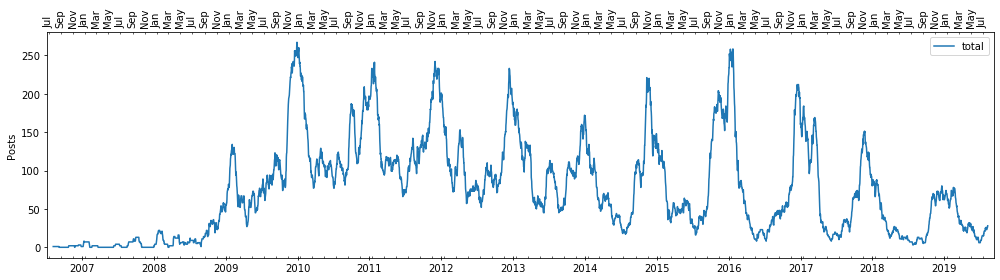

In [17]:
plot_post_timeline(time_df, cols=['total'])

Seasonality seems to play a fairly substantial role in the dataset. As one might expect, posts drop heavily February-September and peaks November-January. This trend has become more pronounced over time went on until the end of 2018, when the total submission dropped heavily. 

Attempting to explain the downward trend in recent years, one might theorize:
* Accumulating content reduced the need for new posts during non-peak season.
* Admissions season became more standardized across schools.
* The site is losing popularity to other resources.
* The site changed in some way that moved posts elsewhere (added new thread topics, for example).
* Top contributors left the site.
* Fewer people are applying to graduate school.

Let's see cross some of these ideas off the list.

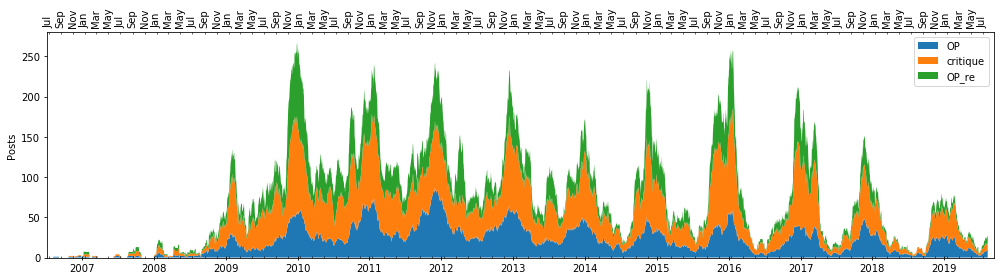

In [18]:
plot_post_timeline(time_df,cols=['OP','critique','OP_re'],plot_type='stacked')

Breaking it down, we see a fairly consistent amount of OP posts across the years, so our last theory is unlikely. Additionally, the number of critiques has always exceeded the number of original posts, by a great amount in most cases. However, because of the 2018-2019 quantities, we can't explicitly rule out the possibility that top contributers have left.

In [19]:
users_df = full_df[['post_date','seqnum','name','username','user_id']].copy()
users_df['username'] = users_df.username.fillna('MISSINGNO') # placeholder for missing usernames

In [20]:
users_df.loc[crit_idx,'username'].value_counts().where(lambda x: x > 10).dropna()[:15]

EF_Kevin         879.0
Holt             640.0
vangiespen       472.0
dumi             345.0
EF_Susan         273.0
justivy03        166.0
EF_Sean          114.0
EF_Simone        109.0
admission2012    100.0
EF_Team5          44.0
lcturn87          42.0
Pahan             42.0
jkjeremy          40.0
linmark           37.0
Maria             35.0
Name: username, dtype: float64

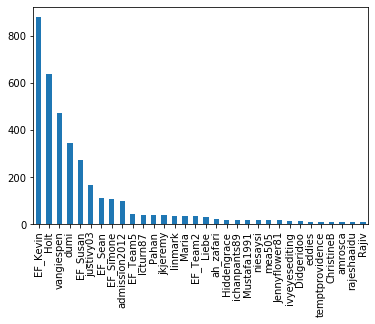

In [21]:
users_df.loc[crit_idx,'username'].value_counts().where(lambda x: x > 10).dropna().plot.bar();

In [22]:
print(users_df.loc[crit_idx,'username'].value_counts().describe())
users_df.loc[crit_idx,'username'].value_counts(normalize=True)[:6].sum()

count    1425.000000
mean        3.883509
std        34.130293
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max       879.000000
Name: username, dtype: float64


0.5014456089627756

Here we can see one of the biggest limitations of this analysis. Despite this being an open forum, over half of the graduate critiques on the site are provided by only 6 people; the vast majority of users have only written a single critique. Our intention was to diversify the information source to gather many unique perspectives on writing so that commonalities can be discovered. With such disproportionate contributions, our findings are again skewed to the opinions of a select few people.

In [23]:
top_contribs = users_df.loc[crit_idx,'username'].value_counts()[np.r_[0:6,14]].index # include 0-6 as well as pos 14

In [24]:
top_contribs_df = users_df.loc[crit_idx,['post_date','username','user_id']
                              ].where(lambda x: x.username.isin(top_contribs)).dropna()
top_contribs_df['post_count'] = 1
top_contribs_df = top_contribs_df.set_index('post_date').drop('user_id',1)

In [25]:
top_contribs_daily = top_contribs_df.pivot_table(index='post_date',columns='username',values='post_count',
                                                 aggfunc='sum',fill_value=0,dropna=False).rename_axis(None).asfreq('d',fill_value=0)
dtc_cumsum = top_contribs_daily.replace(0,np.nan).cumsum() # restore NaN values for a clean chart appearance 
dtc_roll90 = top_contribs_daily.replace(0,np.nan).rolling('90d').sum()

In [26]:
top_contribs_df.pivot_table(index='post_date',columns='username',values='post_count',
                                                 aggfunc='sum',fill_value=0,dropna=False).asfreq('d',fill_value=0)

username,EF_Kevin,EF_Susan,Holt,Maria,dumi,justivy03,vangiespen
post_date,,,,,,,
2008-11-30,1,0,0,0,0,0,0
2008-12-01,3,0,0,0,0,0,0
2008-12-02,0,0,0,0,0,0,0
2008-12-03,0,0,0,0,0,0,0
2008-12-04,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...
2019-08-06,0,0,0,0,0,0,0
2019-08-07,0,0,0,0,0,0,0
2019-08-08,0,0,0,0,0,0,0


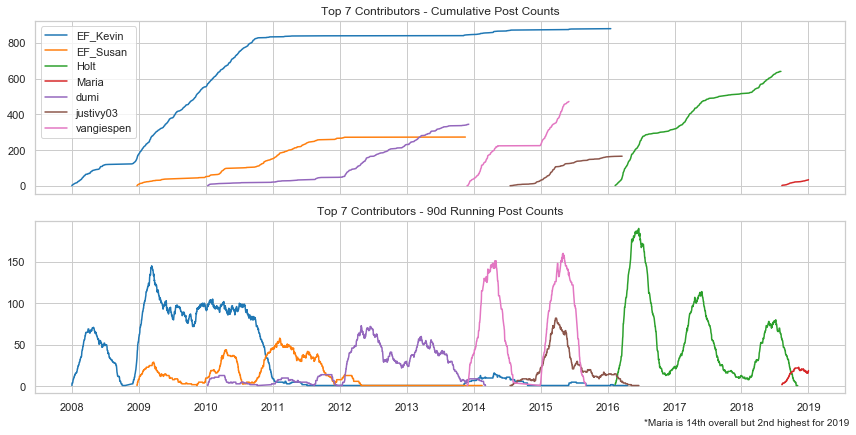

In [28]:
sns.set(style='whitegrid')
fig,axes = plt.subplots(2,1,figsize=(12,6),sharex=True)

sns.lineplot(data=dtc_cumsum, hue=dtc_cumsum.columns, ax=axes[0], dashes=False, palette='tab10')
sns.lineplot(data=dtc_roll90, hue=dtc_roll90.columns, ax=axes[1], dashes=False, palette='tab10', legend=False)

axes[0].set_title('Top 7 Contributors - Cumulative Post Counts')
axes[1].set_title('Top 7 Contributors - 90d Running Post Counts')

full_date_range = pd.date_range(dtc_cumsum.index.min(), dtc_cumsum.index.max(),periods=12)
axes[0].set_xticks(full_date_range)
axes[1].set_xticks(full_date_range)
axes[1].set_xticklabels(full_date_range.year)

plt.figtext(0.99, 0, '*Maria is 15th overall but 2nd highest for 2019', wrap=True, horizontalalignment='right', fontsize=10)
plt.tight_layout()
plt.show()

With this plot in hand, we can now definitively say that most of the large contributors are no longer active in the graduate forum. In fact, the last 3 years have been dominated by a single person's contributions, which again is somewhat troublesome for the main intent of the analysis.

#### Readability Score

In [21]:
cmu = cmudict.dict()
def syllable_count(word):
    # Ref: stackoverflow.com/questions/14541303/count-the-number-of-syllables-in-a-word
    word = word.lower().strip(string.punctuation)
    try: 
        return [len([y for y in x if y[-1].isdigit()]) for x in cmu[word]][0]
    except KeyError:
        # if word not found in cmudict use approximation
        return _syllabify(word)

def _syllabify(word):
    """Fall back method for `syllable_count`, usally accurate to ±1"""
    count = 0
    vowels = set('aeiouy')
    if word[0] in vowels:
        count +=1
    for index in range(1,len(word)):
        if word[index] in vowels and word[index-1] not in vowels:
            count +=1
    if word.endswith('e'): count-=1
    if word.endswith('le') and word[-3] not in vowels: count+=1
    if count == 0: count +=1
    return count

def flesch_score(text, alpha=-1.015, beta=-84.6, gamma=206.835):
    """Calculate Flesch reading-ease score for a given text document.
    
        206.835 - 1.015(total_words/total_sentences) - 84.6(total_syllables/total_words)
    
    Scores will normally span a range of 100-0, where lower values indicate higher reading difficultly.
    
    100.0–90.0: 5th grade
    ...
    60.0–50.0 : 10th to 12th grade
    50.0–30.0 : College
    30.0–0.0  : College graduate
        
    Parameters
    ----------
    text : str or spacy.tokens.doc.Doc, document to score.
    alpha,beta,gamma : float, constants used in original FRES formula. 
        To use Flesch–Kincaid grade level varient, set alpha=0.39, beta=11.8, gamma=-15.59
        
    Returns
    -------
    float - FRE score
    
    References
    ----------
        https://en.wikipedia.org/wiki/Readability
        https://en.wikipedia.org/wiki/Flesch%E2%80%93Kincaid_readability_tests
    """
    doc = nlp(text, disable=['ner']) if isinstance(text,str) else text
    tot_sents = len([*doc.sents])
    all_words = [x for x in doc if str(x).isalpha()]
    tot_words = len(all_words)
    tot_syllables = np.sum([*map(syllable_count, [str(x) for x in doc if str(x).isalpha()])])
    avg_sent_len = (tot_words/tot_sents)
    avg_syllable_word = (tot_syllables/tot_words)
    
    fres = alpha*avg_sent_len + beta*avg_syllable_word + gamma
    
    return fres

In [22]:
fres_vals = df_op.post_content.apply(flesch_score)

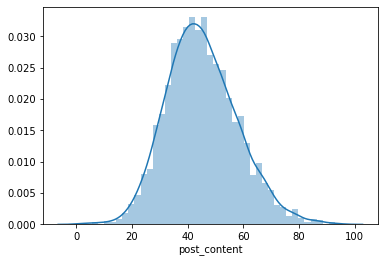

In [23]:
sns.distplot(fres_vals);

In [24]:
fres_vals.describe()

count    3417.000000
mean       45.116562
std        12.725819
min         1.273516
25%        36.272086
50%        44.194392
75%        53.025625
max        94.987143
Name: post_content, dtype: float64

In [25]:
fres_vals[df_op.post_content.str.lower().str.contains(r"statement of purpose|sop|letter of intent")].describe()

count    1182.000000
mean       42.438114
std        11.865871
min         6.636981
25%        34.438167
50%        41.134594
75%        49.001421
max        94.987143
Name: post_content, dtype: float64

#### Word Counts

In [32]:
def strip_spectoks(toklist,striptoks=['xxmaj','xxup']):
    return [x for x in toklist if x not in striptoks]

In [28]:
word_counts = df_op.tokens.apply(strip_spectoks).apply(lambda x: len([w for w in x if w.isalpha()]))

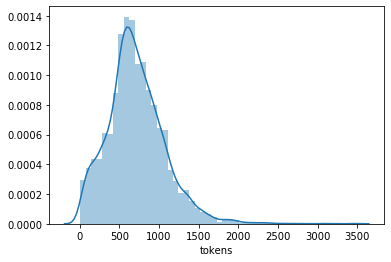

In [29]:
sns.distplot(word_counts);

In [30]:
word_counts.describe()

count    3417.000000
mean      710.462394
std       362.337967
min         6.000000
25%       487.000000
50%       672.000000
75%       911.000000
max      3450.000000
Name: tokens, dtype: float64

If we discount the preamble that most posts begin with, the average post is about 650 words long.

In [36]:
df_sop = df_op[df_op.post_content.str.lower().str.contains('statement of purpose|sop|letter of intent|personal statement')]

In [37]:
sop_wc = df_sop.tokens.apply(strip_spectoks).apply(lambda x: len([w for w in x if w.isalpha()]))

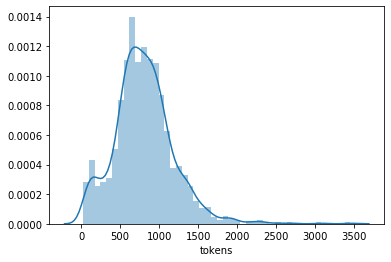

In [38]:
sns.distplot(sop_wc);

In [39]:
sop_wc.describe()

count    1506.000000
mean      803.590969
std       382.915155
min        23.000000
25%       574.000000
50%       779.000000
75%      1006.750000
max      3450.000000
Name: tokens, dtype: float64

Filtering down to statements of purpose, these on average tend to be slightly longer than a general application document.

In [127]:
df_op.post_content.str.lower().str.split()

0        [hi, guys,, i, would, need, help, reviewing, t...
2        [please, confine, your, statement, to, no, mor...
3        [i, really, need, help, in, this, particular, ...
8        [hello, everyone,, i, would, like, to, have, a...
9        [one, of, the, best, economics, graduate, prog...
                               ...                        
11969    [hello, everyone,, i, need, some, help, with, ...
11974    [hi!, i, want, to, apply, for, a, master, prog...
11975    [one, page, intro, for, mba, class., written, ...
11980    [hello, everyone,, it, would, be, much, apprec...
11981    [some, people, think, that, examinations, have...
Name: post_content, Length: 3417, dtype: object

In [33]:
vctzr_params = dict(stop_words=stopwords_lg, strip_accents='ascii', ngram_range=(1,3), max_df=0.8, min_df=5)
count_vctzr = CountVectorizer(**vctzr_params)    
tfidf_vctzr = TfidfVectorizer(**vctzr_params)

In [37]:
count_mat_op = count_vctzr.fit_transform(df_op.post_content)
ftnames = [*map(lambda x: x.replace(' ','_'),count_vctzr.get_feature_names())]

In [65]:
count_df = pd.DataFrame(count_mat_op.todense(), columns=ftnames).T
count_df.assign(freq=count_df.sum(axis=1)).sort_values('freq', ascending=False).head(15)

,0,1,2,3,4,5,6,7,8,9,...,3408,3409,3410,3411,3412,3413,3414,3415,3416,freq
research,7,3,3,8,2,1,2,0,0,10,...,0,2,9,2,0,0,0,6,0,8097
work,5,1,1,4,1,1,2,2,5,5,...,1,0,2,0,3,1,2,0,0,7281
university,7,1,2,4,1,0,1,1,1,0,...,1,0,4,4,3,5,1,0,0,6828
program,7,1,0,5,4,3,3,0,0,0,...,1,6,4,3,4,0,7,1,0,6229
experience,4,3,0,2,2,0,0,1,2,0,...,0,7,2,1,1,0,0,3,0,5513
time,6,0,0,2,2,2,1,5,4,3,...,3,0,3,2,0,1,2,0,0,5215
knowledge,5,2,3,5,2,0,4,0,3,3,...,0,2,4,1,1,1,1,1,0,5158
engineering,10,3,1,0,0,5,0,0,1,0,...,0,3,1,0,0,0,0,0,0,4849
school,2,0,2,0,0,2,0,1,0,2,...,1,0,2,1,1,0,2,0,0,4825
career,3,4,0,0,0,1,0,1,2,0,...,3,1,1,2,1,0,3,0,0,4812


In [42]:
tfidf_vctzr.fit(df_op.post_content)
freq_mat = tfidf_vctzr.transform(df_op.post_content)
feat_names = [*map(lambda x: x.replace(' ','_'),tfidf_vctzr.get_feature_names())] 

As opposed to using the highest sum total as we did with raw word counts, we can use a slightly unorthodox approach and look at the standard deviations associated with each word's tfidf across the documents. In doing so, we can begin to identify words that characterize certain types of documents over others, which is more in line with the intended purpose of tf-idf.

In [46]:
tfidf_df = pd.DataFrame(freq_mat.todense(),columns=feat_names).T
tfidf_df.assign(std_tfidf = tfidf_df.std(axis=1)).sort_values('std_tfidf', ascending=False).head(15)

,0,1,2,3,4,5,6,7,8,9,...,3408,3409,3410,3411,3412,3413,3414,3415,3416,std_tfidf
health,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.438219,0.000000,0.000000,0.000000,0.000000,0.0,0.060088
data,0.000000,0.000000,0.000000,0.021104,0.000000,0.440877,0.308663,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.051552
design,0.000000,0.000000,0.000000,0.038932,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.046938,0.000000,0.043301,0.000000,0.000000,0.102097,0.000000,0.000000,0.0,0.048442
speech,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.047200
engineering,0.104543,0.077219,0.023189,0.000000,0.000000,0.077848,0.000000,0.000000,0.025053,0.000000,...,0.000000,0.049830,0.012710,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.046746
physical,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.045960
business,0.011235,0.000000,0.000000,0.000000,0.039449,0.066931,0.089813,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.022474,0.000000,0.068981,0.000000,0.0,0.044548
xxx,0.000000,0.000000,0.067671,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.033083,0.000000,0.000000,0.070243,0.145749,0.0,0.044473
economics,0.000000,0.000000,0.000000,0.000000,0.507310,0.000000,0.033971,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.044085
energy,0.000000,0.000000,0.034647,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.248176,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.043473


With the approach, we can begin to see different industries emerge from document context. "data" is back near the top, "xxx" is commonly used to obfuscate sensitive data like university names or professors, but now we can see words relating to health, business, and finances taking higher precedence.